<a href="https://colab.research.google.com/github/gkv856/KaggleData/blob/main/Milestone_v001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [304]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset


import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [305]:
LB = -20
UB = 20
SAMPLES = 2000
np.random.seed(42)
X1 = np.random.randint(LB, UB, SAMPLES)
X2 = np.random.randint(LB, UB, SAMPLES)
y = X1 + X2

In [306]:
df = pd.DataFrame([X1, X2]).T
X = df.values
X.shape

(2000, 2)

In [307]:
class FFN_Add(nn.Module):
  
  def __init__(self):
    super().__init__()

    self.inp_layer = nn.Linear(2, 32)
    # self.h1 = nn.Linear(16, 32)
    self.h2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 1)

  def forward(self, x):

    # x = F.relu(self.inp_layer(x))
    x = self.inp_layer(x)
    # x = F.relu(self.h1(x))
    x = F.relu(self.h2(x))
    x = self.output(x)
    
    return x


In [308]:
test_net = FFN_Add()

test_t = torch.tensor((2, -9)).float()

test_net(test_t)

tensor([-0.1601], grad_fn=<AddBackward0>)

In [309]:
def create_model(lr=0.001, momentum=0):

  model = FFN_Add()

  loss_func = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

  return model, loss_func, optimizer


In [310]:
X_train = torch.tensor(X, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)

X_train.shape, y_train.shape

(torch.Size([2000, 2]), torch.Size([2000]))

In [311]:
BATCH_SIZE = 2000

train_dl = TensorDataset(X_train, y_train)
train_ds = DataLoader(train_dl, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [312]:
# next(iter(train_ds))

In [313]:
def get_accuracy(yHat, y, tolerance=0.1):
  # compute accuracy
  matches = abs(yHat - y)<tolerance     # booleans (false/true)
  matchesNumeric = matches.float()             # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
  return accuracyPct               # add to list of accuracies

In [314]:
def create_train_model(train_ds, epochs=400, lr=0.001, momentum=0):

  model, loss_func, optimizer = create_model(lr, momentum)
  train_losses = torch.zeros(epochs)
  
  for epoch in range(epochs):
    # loop over training data batches
    batch_acc  = []
    batch_loss = []
    for X, y in train_ds:
      # forward
      y_preds = model(X)
      y_preds = torch.squeeze(y_preds)
      
      # print(X.shape, y_preds.shape, y.shape)
      # calculating loss and saving in a list
      loss = loss_func(y_preds, y)
      batch_loss.append(loss.item())

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(get_accuracy(y_preds, y))

    # and get average losses across the batches
    train_losses[epoch] = np.mean(batch_loss)
    

  # final forward pass
  with torch.no_grad():
    data = next(iter(train_ds))
    y_preds = model(data[0])
    y_preds = torch.squeeze(y_preds)
  
  # compute the predictions and report accuracy (is this really different from loss?)
  train_acc = 100*torch.mean( (np.abs(y_preds-y)<1).float() ) # <1 for rounding

  return model, y_preds, train_acc, train_losses


In [320]:
model, y_preds, train_acc, train_losses = create_train_model(train_ds, epochs=500, lr=0.0001, momentum=.9)


In [321]:
f"Model accuracy = {train_acc.detach().numpy()} %"

'Model accuracy = 100.0 %'

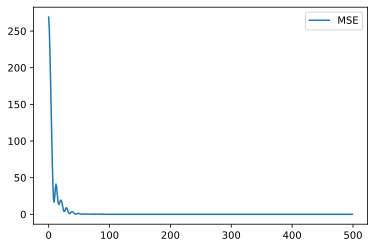

In [322]:
# plt.plot(train_losses)
plt.plot(train_losses)
plt.legend(["MSE"])
plt.show()

In [323]:
t = torch.tensor((20, 20), dtype=torch.float)
torch.round(model(t)), model(t)

(tensor([40.], grad_fn=<RoundBackward>),
 tensor([40.0190], grad_fn=<AddBackward0>))

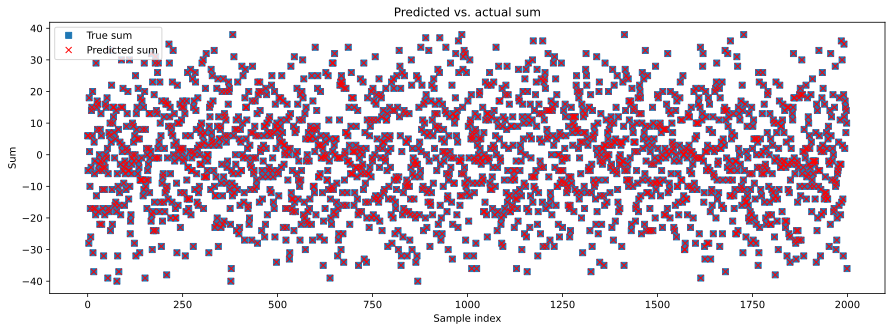

In [324]:
# true and predicted values
fig = plt.figure(figsize=(15,5))
plt.plot(y_train,'s')
plt.plot(np.round(y_preds.detach()),'rx')
plt.legend(['True sum','Predicted sum'])
plt.xlabel('Sample index')
plt.ylabel('Sum')
plt.title('Predicted vs. actual sum')
plt.show()